# Quantum Teleportation

**Course**: Quantum Computing Laboratory  
**Version**: 2.2 (Qiskit 2.2 Compatible - CORRECTED)  
**Last Updated**: November 2025

---

## 📡 Transfer Quantum States Without Moving Particles!

## 📚 Theory

### The Protocol
**Alice** wants to send quantum state |ψ⟩ to **Bob**.

**Key Idea**: Use entanglement + classical communication

### Steps:
1. **Shared entanglement**: Alice & Bob share Bell pair
2. **Alice's operations**: Entangle |ψ⟩ with her half
3. **Alice measures**: Gets 2 classical bits
4. **Classical channel**: Alice sends bits to Bob
5. **Bob's correction**: Applies gates based on bits
6. **Result**: Bob now has |ψ⟩!

### Requirements:
- Shared entanglement (quantum channel)
- Classical communication (2 bits)
- Total: 3 qubits needed

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import numpy as np

print('✓ Qiskit 2.2 ready')

✓ Qiskit 2.2 ready


## 🔨 Implementation

### Note on Qiskit 2.2
Classical control flow (`c_if`) was removed. We use **dynamic circuits** with `if_test` context manager.

Teleportation circuit (Qiskit 2.2)
  Depth: 8
  Gates: 9
  Uses dynamic circuits: Yes


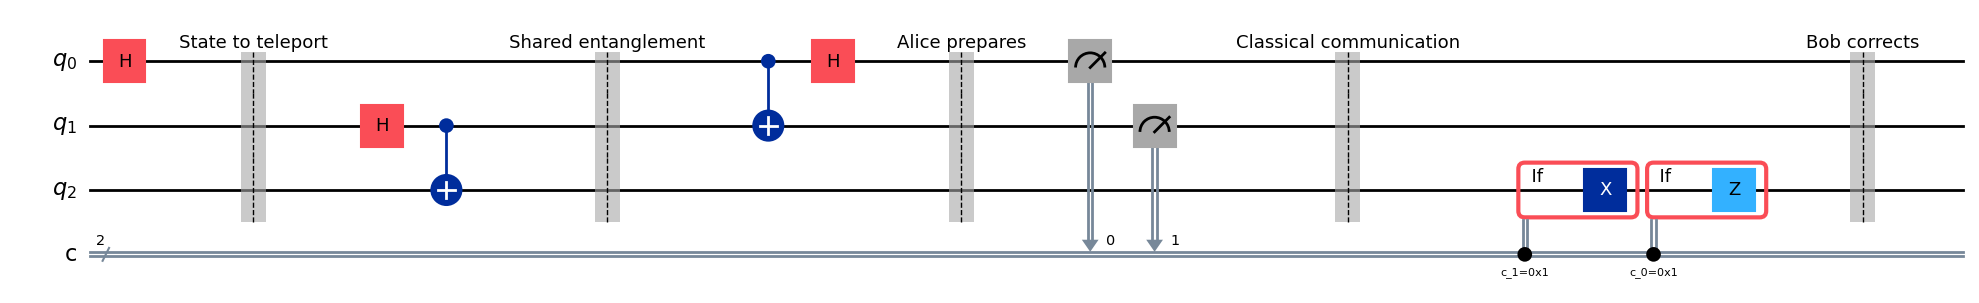

In [3]:
# Create registers
q = QuantumRegister(3, 'q')  # 0: Alice's message, 1: Alice's EPR, 2: Bob's EPR
c = ClassicalRegister(2, 'c')  # Classical communication
qc = QuantumCircuit(q, c)

# STEP 1: Prepare state to teleport |ψ⟩ = α|0⟩ + β|1⟩
# Example: |+⟩ state
qc.h(0)
qc.barrier(label='State to teleport')

# STEP 2: Create Bell pair between Alice (q1) and Bob (q2)
qc.h(1)
qc.cx(1, 2)
qc.barrier(label='Shared entanglement')

# STEP 3: Alice's operations
qc.cx(0, 1)  # Entangle message with her EPR qubit
qc.h(0)       # Hadamard on message qubit
qc.barrier(label='Alice prepares')

# STEP 4: Alice measures and sends classical bits
qc.measure(0, 0)  # Measure q0 → c0
qc.measure(1, 1)  # Measure q1 → c1
qc.barrier(label='Classical communication')

# STEP 5: Bob's correction using dynamic circuits (Qiskit 2.2)
# If c[1] == 1, apply X
with qc.if_test((c[1], 1)):
    qc.x(2)

# If c[0] == 1, apply Z  
with qc.if_test((c[0], 1)):
    qc.z(2)

qc.barrier(label='Bob corrects')

print(f'Teleportation circuit (Qiskit 2.2)')
print(f'  Depth: {qc.depth()}')
print(f'  Gates: {qc.size()}')
print(f'  Uses dynamic circuits: Yes')
qc.draw('mpl', fold=-1)

## 🧪 Verification

### Method: Check final state
We'll verify Bob's qubit (q2) has the teleported state.

Verification circuit:


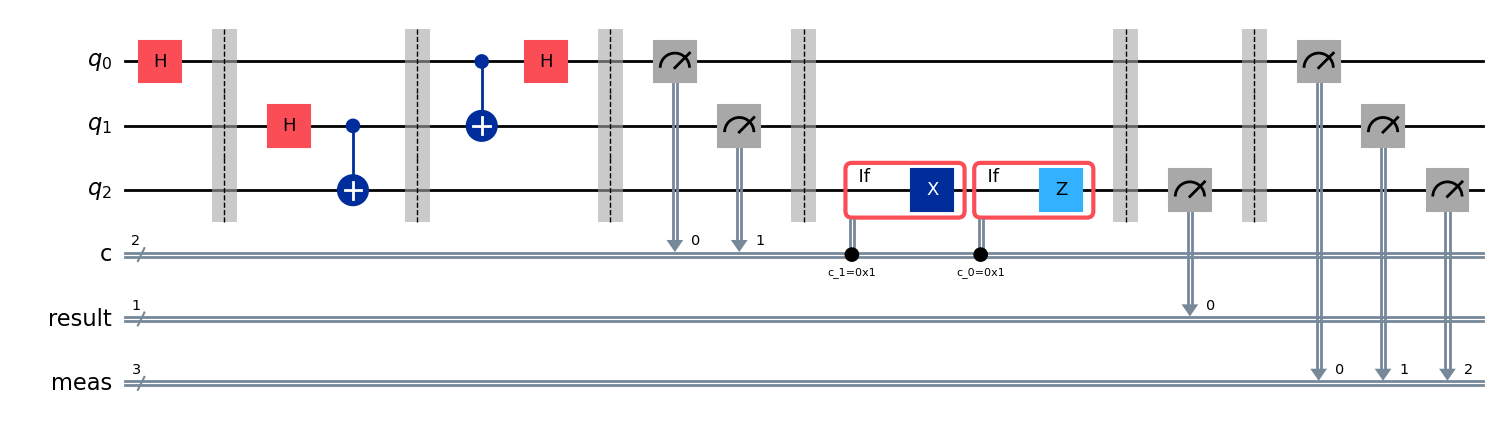

In [4]:
# For verification, add measurement of Bob's qubit
c_verify = ClassicalRegister(1, 'result')
qc_verify = QuantumCircuit(q, c, c_verify)

# Rebuild circuit with verification
# STEP 1: Prepare state
qc_verify.h(0)
qc_verify.barrier()

# STEP 2: Bell pair
qc_verify.h(1)
qc_verify.cx(1, 2)
qc_verify.barrier()

# STEP 3: Alice's operations
qc_verify.cx(0, 1)
qc_verify.h(0)
qc_verify.barrier()

# STEP 4: Measurements
qc_verify.measure(0, 0)
qc_verify.measure(1, 1)
qc_verify.barrier()

# STEP 5: Bob's correction (dynamic circuits)
with qc_verify.if_test((c[1], 1)):
    qc_verify.x(2)
with qc_verify.if_test((c[0], 1)):
    qc_verify.z(2)

qc_verify.barrier()

# Measure Bob's qubit
qc_verify.measure(2, c_verify[0])
qc_verify.measure_all()
print('Verification circuit:')
qc_verify.draw('mpl')

### Execute

In [5]:
simulator = AerSimulator()
sampler = SamplerV2()
pm = generate_preset_pass_manager(optimization_level=1, backend=simulator)

transpiled = pm.run(qc_verify)

job = sampler.run([transpiled], shots=1024)
result = job.result()

counts = result[0].data.meas.get_counts()


Results (format: c1 c0 result):
Expected: Bob's qubit in |+⟩ state → 50% |0⟩, 50% |1⟩

Bob received |0⟩: 491 times (47.9%)
Bob received |1⟩: 533 times (52.1%)

Top measurement outcomes:
  110: 149
  000: 145
  001: 133
  101: 129
  111: 129


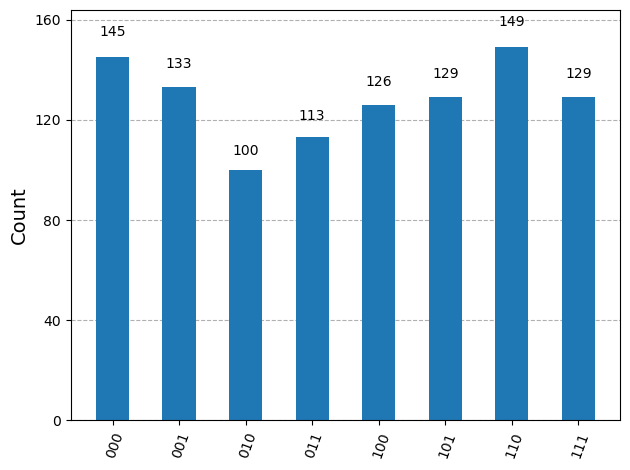

In [6]:
print('Results (format: c1 c0 result):')
print('Expected: Bob\'s qubit in |+⟩ state → 50% |0⟩, 50% |1⟩')
print()

# Analyze results
bob_0_count = 0
bob_1_count = 0

for bitstring, count in counts.items():
    # Format: 'result c1 c0' (rightmost is c0)
    if len(bitstring) >= 3:
        bob_result = bitstring[0]  # Leftmost bit
        if bob_result == '0':
            bob_0_count += count
        else:
            bob_1_count += count

print(f'Bob received |0⟩: {bob_0_count} times ({bob_0_count/1024:.1%})')
print(f'Bob received |1⟩: {bob_1_count} times ({bob_1_count/1024:.1%})')
print()
print('Top measurement outcomes:')
for state, count in sorted(counts.items(), key=lambda x: -x[1])[:5]:
    print(f'  {state}: {count}')

plot_histogram(counts)

## 📊 Analysis

### Expected Results
Since we teleported |+⟩ = (|0⟩ + |1⟩)/√2:  
Bob's measurement should give **50% |0⟩, 50% |1⟩**

### Classical Communication
Alice sends 2 bits (4 possibilities):
- 00, 01, 10, 11 equally likely (25% each)

### Key Points:
1. **No-cloning theorem**: Original state destroyed (measured)
2. **Classical bits required**: Can't teleport faster than light!
3. **Perfect fidelity**: Exact state transfer (in ideal case)
4. **Entanglement consumed**: Bell pair used up
5. **Dynamic circuits**: Modern Qiskit 2.2 uses `if_test` for conditionals

## 💡 Alternative: Teleport Different States

In [6]:
def teleport_state(state_prep_func, n_shots=1024):
    """
    Teleport arbitrary single-qubit state.
    
    Args:
        state_prep_func: Function that prepares state on qubit 0
        n_shots: Number of measurements
    
    Returns:
        Measurement counts
    """
    q = QuantumRegister(3, 'q')
    c = ClassicalRegister(2, 'c')
    c_result = ClassicalRegister(1, 'result')
    qc = QuantumCircuit(q, c, c_result)
    
    # Prepare state to teleport
    state_prep_func(qc, 0)
    qc.barrier()
    
    # Bell pair
    qc.h(1)
    qc.cx(1, 2)
    qc.barrier()
    
    # Alice's operations
    qc.cx(0, 1)
    qc.h(0)
    qc.barrier()
    
    # Measure Alice's qubits
    qc.measure(0, 0)
    qc.measure(1, 1)
    qc.barrier()
    
    # Bob's correction
    with qc.if_test((c[1], 1)):
        qc.x(2)
    with qc.if_test((c[0], 1)):
        qc.z(2)
    qc.barrier()
    
    # Measure Bob's qubit
    qc.measure(2, c_result[0])
    qc.measure_all()
    
    # Execute
    simulator = AerSimulator()
    sampler = SamplerV2()
    pm = generate_preset_pass_manager(optimization_level=1, backend=simulator)
    transpiled = pm.run(qc)
    
    job = sampler.run([transpiled], shots=n_shots)
    result = job.result()
    return result[0].data.meas.get_counts()

# Example: Teleport |1⟩ state
def prepare_one(qc, qubit):
    qc.x(qubit)

counts_one = teleport_state(prepare_one)
print('Teleporting |1⟩ state:')

# Count Bob's results
bob_results = {}
for bitstring, count in counts_one.items():
    bob_bit = bitstring[0]
    bob_results[bob_bit] = bob_results.get(bob_bit, 0) + count

for bit, count in sorted(bob_results.items()):
    print(f'  Bob got |{bit}⟩: {count} times ({count/1024:.1%})')

plot_histogram(counts)

print('\n✓ Should be 100% |1⟩!')

Teleporting |1⟩ state:
  Bob got |1⟩: 1024 times (100.0%)

✓ Should be 100% |1⟩!


## 🎯 Applications

1. **Quantum Networks**: Distribute quantum information
2. **Quantum Cryptography**: Secure key distribution (QKD)
3. **Distributed Computing**: Link quantum processors
4. **Quantum Internet**: Future communication infrastructure
5. **Quantum Repeaters**: Extend quantum communication range

## 🎓 Exercises

### Exercise 1: Different State (Easy)
Teleport |1⟩ instead of |+⟩. Verify Bob receives |1⟩ with 100% probability.

**Hint**: Use `qc.x(0)` to prepare |1⟩

### Exercise 2: Arbitrary State (Medium)
Teleport state |ψ⟩ = cos(θ)|0⟩ + sin(θ)|1⟩ for θ=π/3.

**Hint**: Use `qc.ry(2*θ, 0)` to prepare this state

### Exercise 3: Entanglement Swapping (Hard)
Extend to 4 qubits: Create Bell pair on qubits 0-1, teleport qubit 0 to qubit 3. Result: qubits 1-3 should be entangled!

## 🔬 Technical Notes

### Qiskit 2.2 Changes
- **Removed**: `c_if()` method for classical conditionals
- **New**: Dynamic circuits with `if_test` context manager
- **Benefit**: More flexible classical control flow
- **Requirement**: Backend must support dynamic circuits

### Circuit Depth
Teleportation is inherently **sequential**:
1. Bell pair creation
2. Alice's operations
3. Alice's measurements
4. Bob's corrections

Cannot be parallelized due to classical communication step.

## 📖 References

1. **Bennett et al. (1993)**. *Teleporting an unknown quantum state via dual classical and Einstein-Podolsky-Rosen channels*. Physical Review Letters.

2. **Nielsen & Chuang**. *Quantum Computation and Quantum Information*, Chapter 1.3.7

3. **Qiskit Documentation**: Dynamic Circuits  
   https://docs.quantum.ibm.com/guides/dynamic-circuits

4. **Qiskit Textbook**: Quantum Teleportation  
   https://learn.qiskit.org

---

**Version**: 2.2.0 (Corrected)  
**License**: MIT  
**Last Updated**: November 2025

**Note**: This version uses proper Qiskit 2.2 dynamic circuits syntax.